# Getting started

This getting started guide will walk you through

 - the creation of your first plot in uhepp format,
 - how to save and load plots locally and,
 - how to interact with the API of uhepp.org.

The guide expects that you have some basic experience in Python. You need to be familiar with functions and objects in Python, however, you don't need to be a library developer. The whole uhepp eco-system does not rely on ROOT, therefore, it's not a disadvantage if you are not familiar with ROOT. You should have a working installation of Python 3 on your machine. The guide will install additional Python packages. The guide expects you to install packages, either in your home directory, system-wide, or in a virtual environment.

This guide will not show you how to process HEP data. It is assumed that you have an analysis framework in place that iterates over individual events and whose output is a histograms collection. These might be ROOT TH1 histograms or numpy arrays produced with Numpy, Pandas, Dask, PySpark, or Caffea. For this guide, we will read sample histograms, including statistical uncertainty from a JSON file.

## Install requirements

In principle, you only need a text editor to write and edit JSON or YAML files and a simple tool like curl to interact with the API. However, this would be extremely cumbersome. It is much more convenient to use the uhepp Python package for both tasks. The package provides an interface to create and manipulate plots in uhepp format stored locally or remotely via the API.

For this guide, we will need the `uhepp` and `requests` package to work with the toy data. Make sure the following package is installed. If you use pip, run:

```bash
pip install uhepp requests
```

To test that it is installed, open an interactive Python 3 shell and type

In [1]:
import requests
import uhepp

Keep the shell open, we will use it trough out this guide.

## Create your first plot

Creating a plot with uhepp involved two tightly coupled but still separated tasks. First, we need to add the raw histogram contents. Afterward, we can set up the visual appearance of the plot.

### Raw data

The first step is to load the sample histograms from a prepared JSON file.  We will [download the toy data](https://gitlab.sauerburger.com/cern/fsauerbu/uhepp/-/raw/master/docs/toyhisto.json) from a GitLab repository. This tutorial will use `requests` to download the file and parse the JSON on the fly.

In [2]:
DATA_URL = "https://gitlab.sauerburger.com/cern/fsauerbu/uhepp/-/raw/master/docs/toyhisto.json"
toydata = requests.get(DATA_URL).json()

The `toydata` variable is a dictionary, contains binned yields for three processes: Simulated background (bkg), simulated signal (sig), and measured data. (Here, in this example, even the measure data is taken from a random generator.) Besides the yields, the variable also contains the statistical uncertainty for each bin and process. Additionally, the dictionary contains the key bin_edges. This variable stores the boundaries of the bins. Feel free to explore the data in your shell. For example, run

In [3]:
print(toydata["bkg"])

[0.38476131306473815, 0.6852710350460031, 1.7207156839990556, 0.0, 2.8308405623840565, 4.0549770212878675, 5.57300699977592, 7.591543782837617, 12.13708713548585, 15.913666346814601, 18.5119900031778, 23.88618979127034, 30.019646840475104, 41.61652455284508, 46.602998183358295, 51.42363524234844, 43.92248543679045, 44.891664438449766, 40.488581031599495, 33.42807275917818, 17.59299466369191, 21.105542096584088, 9.273034869562252, 5.021636967998518, 2.694741424994959, 3.603462408442283, 0.3354262885936805, 0.7772487556835586, 0.0, 0.3308584281754179, 0.471742727544779, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


or

In [4]:
print(toydata["sig_stat"])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19577515884588487, 0.320019978148849, 0.33110021101888526, 0.5208840004818056, 0.6396045713812509, 0.7281262404641017, 0.846256380979379, 0.8907322253814467, 1.0681261828724806, 1.0911717450407639, 0.991076322718083, 1.0591769666174482, 1.0976550831183312, 0.9730515941582837, 0.9395782774358155, 0.8973089778473059, 0.7007885754941169, 0.6196871081239709, 0.5819549508292591, 0.4978869022937864, 0.4515592318838932, 0.30267826071959775, 0.18549896395226498, 0.14203642969452882, 0.13900129897446561, 0.0920435947179317, 0.1192075877406717]


in your interactive Python shell.

You might have noticed that there are 41 bin edges. This means you would expect 40 bins. However, the binned data lists have 42 entries. The additional two values correspond to the under- and overflow bins. By convention, these two bins are always included in the raw data of a uhepp histogram. It is up to you to tell uhepp to include these events in the visual plot or not.

A uhepp histogram stores the raw data separated from the visual specification. Let's start by creating a UHeppHist object and adding the raw data to the histogram. When you create a histogram object, the first argument is the mathematical symbol of the quantity of the x-axis. In our case, the data represents a mass distribution, so we use the letter m. The second argument is the bin boundaries. We take them directly from the `toydata` dictionary.

In [5]:
hist = uhepp.UHeppHist("$m$", toydata["bin_edges"])

The raw data is stored in the yields attribute. It is another dictionary mapping arbitrary internal names to the binned data. The binned data is stored as Yield objects. The yield objects couple the value with its uncertainties. A yield object comes close to a ROOT TH1 object (with some key distinctions). Yield objects can be added, scales, etc., while propagating uncertainties. Let's first create the yield objects from the sample data.

In [6]:
signal_yield     = uhepp.Yield(toydata["sig"],  toydata["sig_stat"])
background_yield = uhepp.Yield(toydata["bkg"],  toydata["bkg_stat"])
data_yield       = uhepp.Yield(toydata["data"], toydata["data_stat"])

Finally, let's add the yields to our histogram.

In [7]:
hist.yields = {
    "signal":     signal_yield,
    "background": background_yield,
    "data":       data_yield
}

The names that we use here as dictionary keys, can be arbitrary strings. You are encouraged to use descriptive names, which makes editing the histogram much easier. We will use these names later to refer to the yields when we specify the main plot's content or the ratio plot. In this example, we've created a single background entry. In a real-world histogram, you would have several different physics processes with one entry per process. You are encouraged to use a fine-grained process list here. Merging two or more yield entries in the visual specification is easy.

### Visual settings

From the visual point of view, uhepp histograms are made up of a list of stacks. A stack consists of stack items. The bin contents of stack items within a stack are added (*stacked*). Separate stacks are down on top of each other. A stack in this context does not only refer to a bar histogram (`stepfilled`). It could be only the outline of bar histogram (`step`) or `points` usually used for measured data.

Let's start by setting up a stack for the signal and background expectation (here `mc` for Monte Carlo). This stack consists of one stack item for the `signal` and one for the `background`.

In [8]:
background_si = uhepp.StackItem(["background"], "Background")
signal_si = uhepp.StackItem(["signal"], "Signal", color="red")

The creation of a `StackItem` takes at least two arguments. The first argument is a list of yield names we've defined in the previous section. Here you see the real power of separating the yield data from their stack definition. By passing multiple processes to the first argument, we can merge histograms with a single line of Python code. The second argument is used as the label in the legend. This is also the time to specify the color, line style, and other style settings. We choose to have the signal in red and leave the background color up to the system.

The stack items need to be combined into a `Stack`. This tells the renderer to *stack* the bars of each stack item vertically. Finally, we can add the `mc_stack` to the stack list of our histogram object.

In [9]:
mc_stack = uhepp.Stack([background_si, signal_si])
hist.stacks.append(mc_stack)

We proceed similarly with data. Here we have a single item in the stack. The type of the stack should be `points`.

In [10]:
data_si = uhepp.StackItem(["data"], "Data")

data_stack = uhepp.Stack([data_si], bartype="points")
hist.stacks.append(data_stack)

To improve the output, we can also make the label of the x-axis more verbose. In the beginning, we've set the symbol already to `m`. Here we add a verbose label `Mass` and the unit `GeV`. On top, we can add some metadata. Some tools use the filename attribute to have a default filename, for example, when you render the plot to graphics file.

In [11]:
hist.variable = "Mass"
hist.unit = "GeV"
hist.filename = "higgs_mass_dist"
hist.author = "Your name"

Now it is time to see how far we've got.

(<Figure size 360x324 with 1 Axes>,
 <AxesSubplot:xlabel='Mass $m$ / GeV', ylabel='Events / 5 GeV'>)

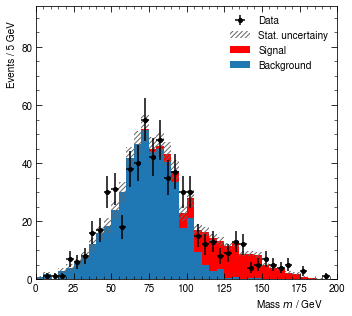

In [12]:
hist.render()
# hist.show()   if you're not in a Jupyter notebook

So far so good. However, we realize that a ratio plot between data and the `background` plus `signal` model would have been nice. Adding a ratio plot is a matter of adding a `RatioItem` to the `ratio` list property. The two mandatory arguments of `RatioItem` are two lists of yield names: First, the one of the numerator. Second, the one for the denominator.

(<Figure size 360x360 with 2 Axes>,
 (<AxesSubplot:ylabel='Events / 5 GeV'>,
  <AxesSubplot:xlabel='Mass $m$ / GeV'>))

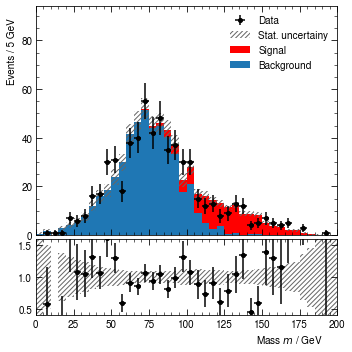

In [13]:
ratio_si = uhepp.RatioItem(["data"], ["signal", "background"], bartype="points")
hist.ratio = [ratio_si]

hist.render()

Can you update the above example, to have the comparison of data against the background-only model?

You might interject that the binning is a bit too fine, and the statistical power of each bin is relatively low. No problem. We can rebin the histogram on the fly during rendering. Simply set an alternative binning. The original histograms are not modified, so you can always undo this step without rerunning your analysis framework.

(<Figure size 360x360 with 2 Axes>,
 (<AxesSubplot:ylabel='Events / 20 GeV'>,
  <AxesSubplot:xlabel='Mass $m$ / GeV'>))

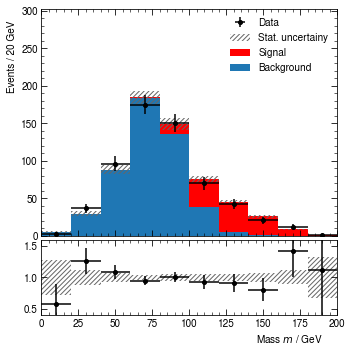

In [14]:
coarser_bins = hist.bin_edges[::4]  # Keep only every fourth bin edge
hist.rebin_edges = coarser_bins
hist.render()

To save the result as a graphics file, call the `render` method with a filename.

(<Figure size 360x360 with 2 Axes>,
 (<AxesSubplot:ylabel='Events / 20 GeV'>,
  <AxesSubplot:xlabel='Mass $m$ / GeV'>))

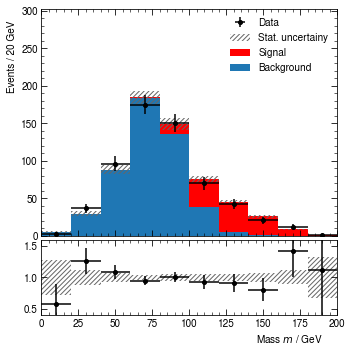

In [15]:
hist.render("mass_dist.pdf")

## Local storage

At this point, we might want to save the result not only in a graphics file but also as a uhepp plot. The whole point of uhepp is that you can save the intermediate result between raw data and graphics files such that you can make modifications to the visual appearance without reprocessing your data set.

The uhepp format does not define the syntax of the file format, only its semantics. You can use any semi-structured format that supports lists and maps. Popular choices are JSON or YAML. We will use JSON in this tutorial.

In [16]:
hist.to_json("mass_hist.json")

Uhep plots stored in JSON or YAML can be modifed with many popular tools. You could even change labels or style settings manually with a text editor. Loading previously saved histograms is also easy.

(<Figure size 360x360 with 2 Axes>,
 (<AxesSubplot:ylabel='Events / 20 GeV'>,
  <AxesSubplot:xlabel='Mass $m$ / GeV'>))

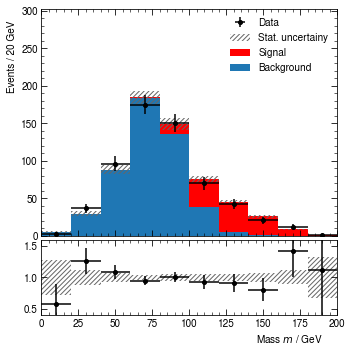

In [17]:
# Could be in a new Python session
import uhepp
loaded_hist = uhepp.from_json("mass_hist.json")
loaded_hist.render()

Think about your recent work. Was there a moment when you wanted to modify the labels, axis ranges, collaboration badges, color scheme, binning, histogram content etc., after the plots have been produced? Had you stored the intermediate data in uhepp format, these tasks are trivial.

## Online storage

In high-energy physics, a common task is to processes enormous data sets. Often this is only possible with a computing cluster. The resulting histograms and plots are stored on a remote file system. To see what the analysis code did, one has to copy the files to the local computer.

Today, high-energy experiments can only be built and maintained by large collaborations. The actual analysis of the data takes place in a team. Showing histograms to colleagues is a daily recurring task. To me, it was both tedious and unsatisfactory to prepare a PDF plot books.

Wouldn't it be nice to have a central hub for all plots? Computing nodes can push histograms in uhepp format to the hub. The analyzer can review plots in realtime; colleagues can browse through the plots online, extract yields, download them, or even upload modified (e.g., rebinned) versions themself. Students could also benefit from a central hub. On the hub, a student can collect plots and histograms throughout the whole time as a student. Naturally, things like color schemes, process compositions, etc., evolve during the time as a student, however, in the thesis, it would be nice to present the material uniformly. If all the material is stored on the hub in uhepp format, it's easy to rebrand, recolor the histogram.

Sounds cool? Then sign up.

 - Go to [https://uhepp.org/login](https://uhepp.org/login) and login using your CERN account and CERN's Single Sign-On.
 - To use the API, you need an API token that is linked to your account. Go to [https://uhepp.org/tokens/new](https://uhepp.org/tokens/new) and create a token. Follow the instructions given on the token creation page. You need to add the token and the API endpoint to your environment variables.
 - Plots on the uhepp hub are organized in collections. We will push the toy plot from the previous section to a new collection. Navigate to [https://uhepp.org/c/new](https://uhepp.org/c/new) and create a new collection. On the collection page, you see the ID of the collection. We need to specify this ID when we want to push or pull plots. For this tutorial, we assume the ID is `1`.
 
Now, you are ready to push your first plot.

In [18]:
hist.push(1)

https://uhepp.org/p/a378d2b0-cde2-4266-be9b-85945d94880d

The return value of `push()` is a push receipt. By default, it renders to the URL where you can view the plot online. Every plot has a unique identifier (uuid). You can see the uuid in the URL. The push receipt gives you programmatic access to the generated uuid.

In [19]:
receipt = _18  # Take the return value of the previous cell
receipt.uuid

'a378d2b0-cde2-4266-be9b-85945d94880d'

If you have the uuid of a plot, you can also download it. The uhepp module provides the `pull()` method for this purpose.

In [20]:
# This could be a new shell again or a different compute
import uhepp
uuid = 'a378d2b0-cde2-4266-be9b-85945d94880d'
hist = uhepp.pull(uuid)

(<Figure size 360x360 with 2 Axes>,
 (<AxesSubplot:ylabel='Events / 20 GeV'>,
  <AxesSubplot:xlabel='Mass $m$ / GeV'>))

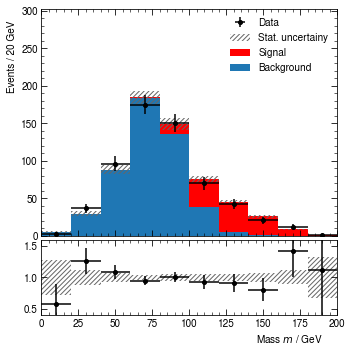

In [21]:
hist.render()

At this point, we might decide that the binning should be a bit finer again, and signal should be `C1` orange instead of red. So let's change this.

(<Figure size 360x360 with 2 Axes>,
 (<AxesSubplot:ylabel='Events / 10 GeV'>,
  <AxesSubplot:xlabel='Mass $m$ / GeV'>))

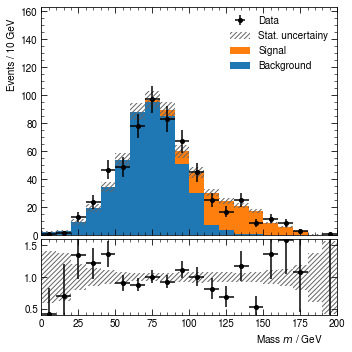

In [22]:
hist.rebin_edges = hist.bin_edges[::2]  # Drop only every second bin edges
hist.stacks[0].content[1].color = 'C1'  # 0-th stack, 1-st stack-item
hist.render()